# Leiden annotation

In [1]:
import scvi
import scanpy as sc

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
import os

## Root directory

In [2]:
os.chdir('/research/peer/fdeckert/FD20200109SPLENO')

## Custom modules

In [3]:
sys.path.append('bin/')
from adata_qc import *

## Settup rpy2 

In [4]:
os.environ['R_HOME'] = '/nobackup/peer/fdeckert/miniconda3/envs/r.4.4.1-FD20200109SPLENO/lib/R'

In [5]:
import rpy2
%load_ext rpy2.ipython

## Figures 

In [6]:
sc.set_figure_params(figsize=(5, 5), dpi_save=1200, fontsize=12, frameon=False, facecolor='white')
mpl.rcParams['figure.facecolor'] = 'white'

In [7]:
# Load color 
import rpy2.robjects as robjects
color_load = robjects.r.source('plotting_global.R')
color = dict()
for i in range(len(color_load[0])):
    color[color_load[0].names[i]] = {key : color_load[0][i].rx2(key)[0] for key in color_load[0][i].names}

In [8]:
# Set color function 
def set_color(categories): 
    
    categories = [x for x in categories if x in list(adata.obs.columns)]

    for category in categories: 

        adata.obs[category] = pd.Series(adata.obs[category], dtype='category').cat.remove_unused_categories()
        
        keys = list(color[category].keys())
        keys = [x for x in keys if x in list(adata.obs[category])]        

        adata.obs[category] = adata.obs[category].cat.reorder_categories(keys)
        adata.uns[category+'_colors'] = np.array([color[category].get(key) for key in keys], dtype=object)

## Cell type marker genes

In [9]:
celltype_genes_dict = {
    
    'Cycling': ['Mki67'], 
    'Immmune': ['Ptprc'], 
    'MHC-I': ['H2-K1'], 
    'MHC-II': ['H2-Ab1'], 
    'Migration': ['Cx3cr1', 'Ccr2', 'Ccr5', 'Cxcr2', 'Ccr7', 'Ccr1'], # Cx3cr1:RP Mo, Ccr2:RP Mo, Ccr5:RP DC, Cxcr2:RP Neu, Ccr7:WP cDC, MG
    
    'MHC': ['H2-D1', 'H2-Ab1'], 
    
    'CD4': ['Cd4'], 
    'CD8': ['Cd8a', 'Cd8b1'], 
    
    'Progenitor': ['Cd34', 'Kit', 'Flt3', 'Slamf1', 'Ly6a', 'Cd48', 'Il7r', 'Cebpa', 'Irf8', 'Csf1r'], 
    'Lin': ['Cd3e', 'Cd19', 'Ly6g', 'Ly6c1', 'Ly6c2', 'Itgam', 'Gypa'], 
    
    'Neutrophil': ['Elane', 'Gfi1'],  
    'Eo': ['Prg2', 'Prg3'],  
    'Basophil': ['Mcpt8', 'Prss34', 'Fcer1a', 'Cd200r3', 'Clec12a'], # https://www.nature.com/articles/s41467-023-38356-1
    'Mast': ['Gzmb', 'Cma1', 'Mcpt1', 'Mcpt4'], 
    
    'Mo': ['Csf1r', 'Ccr2', 'Ly6c2', 'Cx3cr1'],
    'RPM': ['Adgre1', 'Spic', 'Siglec1'], 

    'cDC': ['Zbtb46', 'Flt3', 'Itgax'], 
    'cDC1': ['Xcr1', 'Clec9a', 'Itgae'],
    'cDC2': ['Itgam', 'Sirpa', 'Clec10a', 'Esam', 'Cxcr1', 'Cxcl13'],
    'pDC': ['Siglech', 'Il3ra', 'Tcf4', 'Clec4b1', 'Ly6d'],

    'Meg': ['Pf4', 'Itga2b'],

    'Erythroid': ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hbb-bt', 'Hba-x'], 
    
    'T synapse': ['Trac', 'Trbc1', 'Trbc2', 'Trdc', 'Cd3e', 'Cd3d', 'Cd3g', 'Cd247'], 
    
    'B cell': ['Ms4a1', 'Ighm', 'Ighd', 'Igha', 'Ly6k']
    
}

# Import QC data 

In [10]:
adata = sc.read_h5ad('data/scRNAseq/object/qc.h5ad')

In [11]:
sc.tl.leiden(adata, resolution=0.10, restrict_to=('leiden', ['3']), flavor='igraph', n_iterations=2, key_added='leiden_restrict')
sc.tl.leiden(adata, resolution=0.25, restrict_to=('leiden_restrict', ['10']), flavor='igraph', n_iterations=2, key_added='leiden_restrict')
sc.tl.leiden(adata, resolution=0.10, restrict_to=('leiden_restrict', ['20']), flavor='igraph', n_iterations=2, key_added='leiden_restrict')

adata.obs['leiden'] = adata.obs['leiden_restrict']
del adata.obs['leiden_restrict']

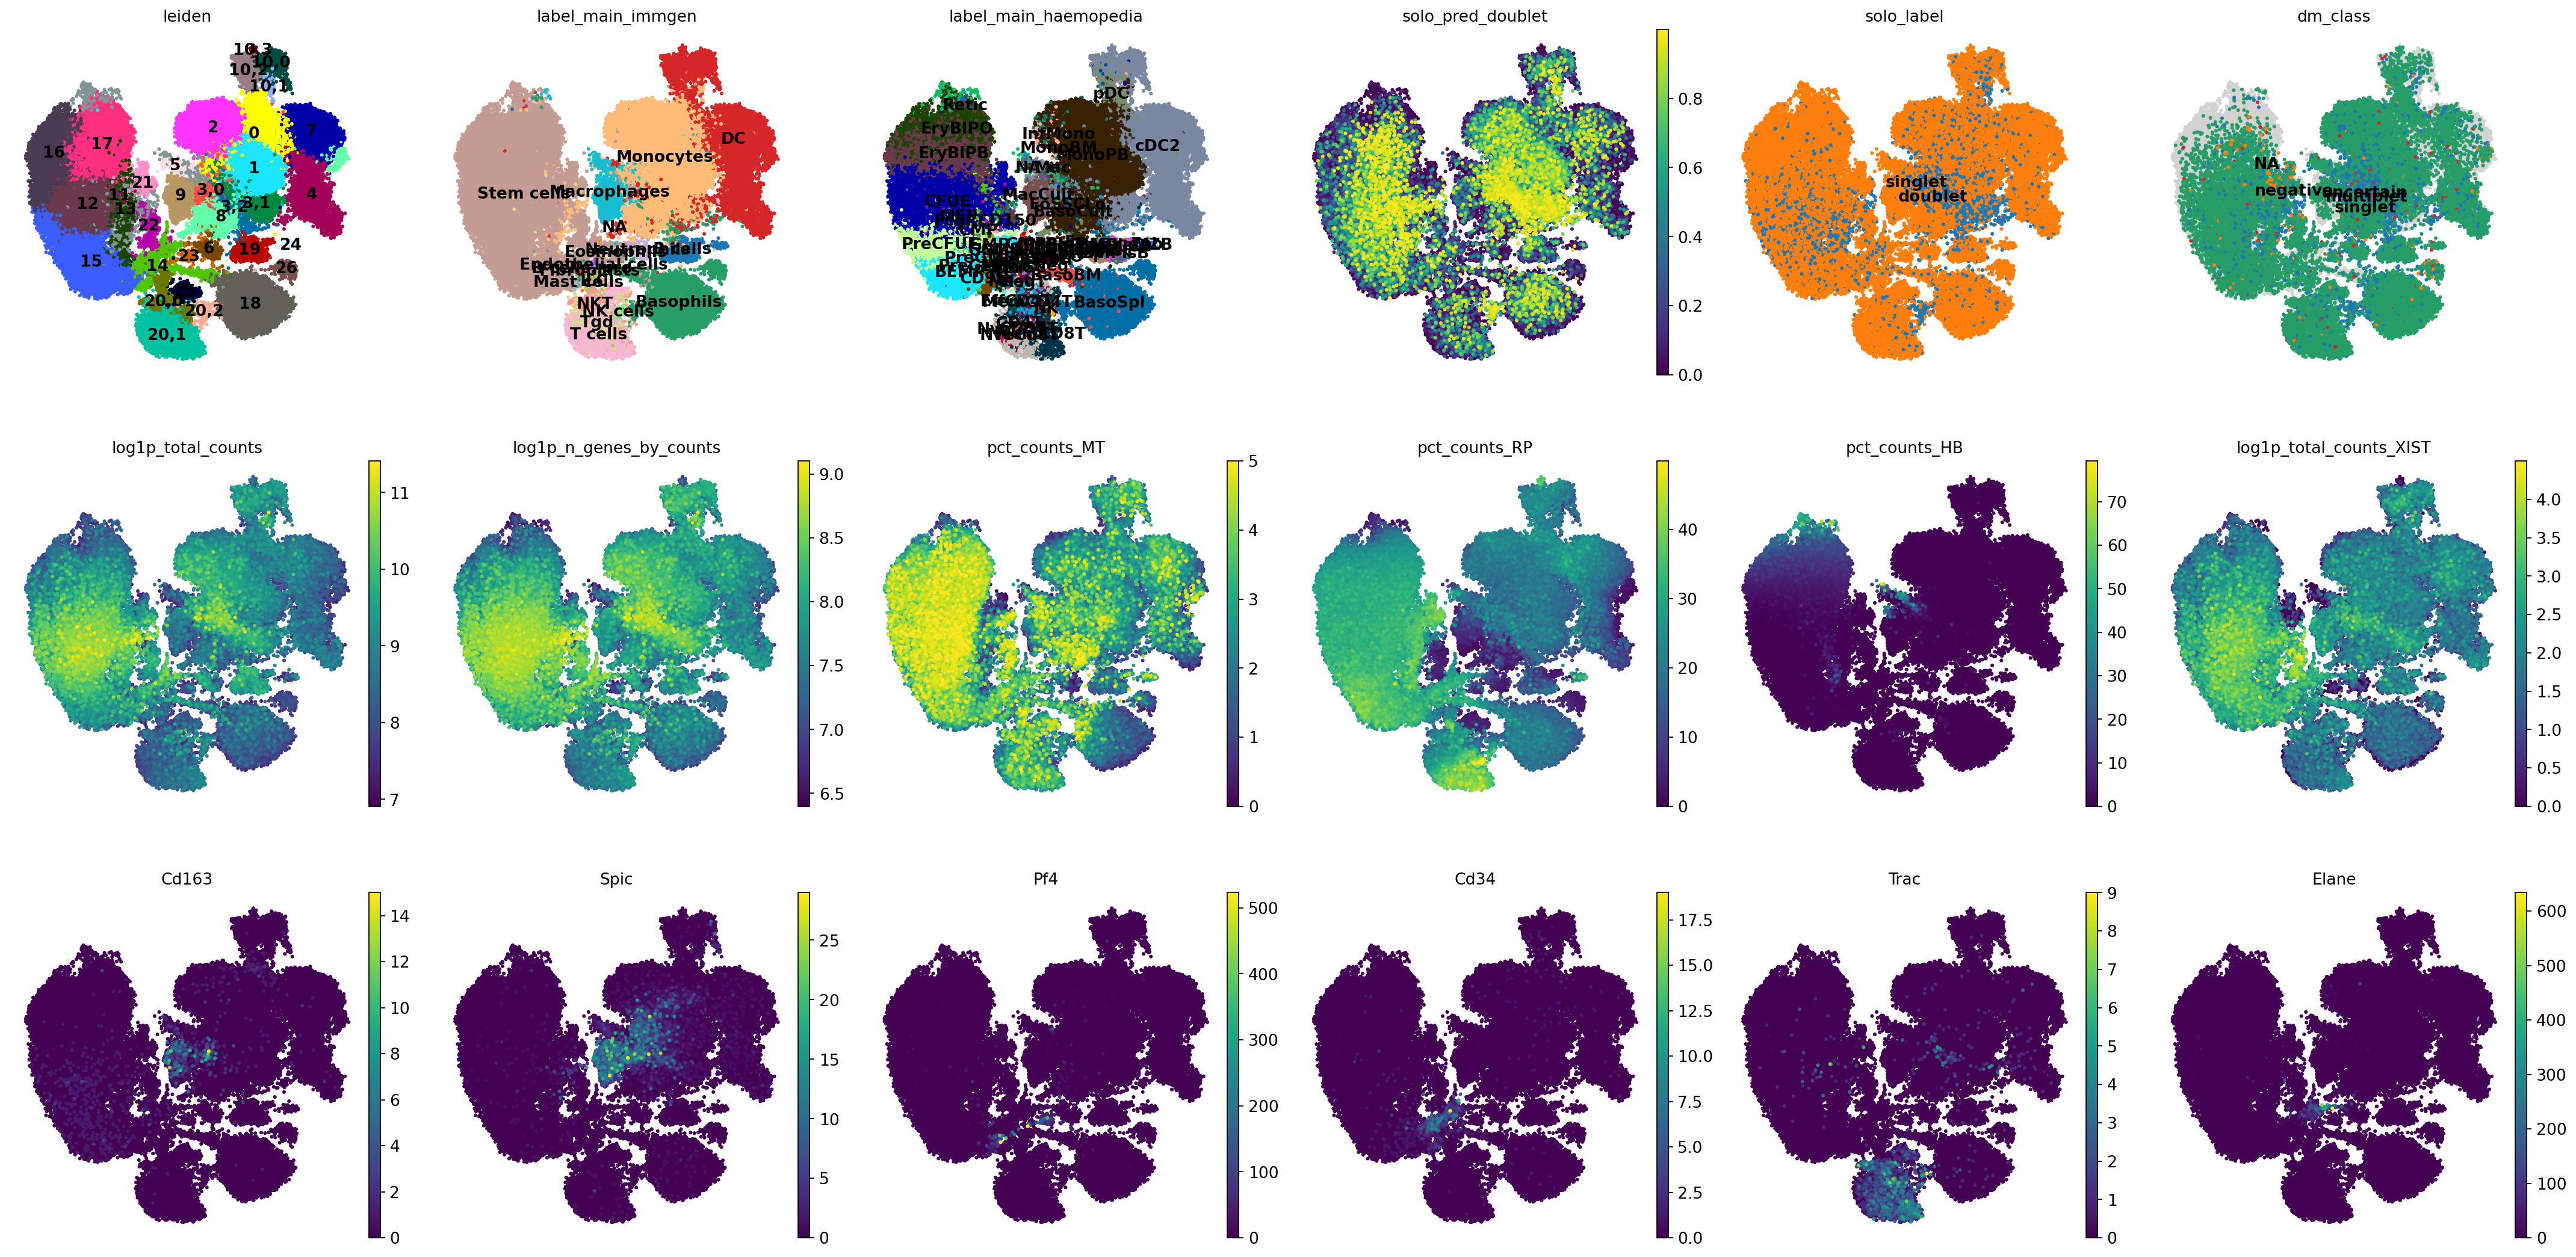

In [12]:
sc.pl.umap(adata, color=['leiden', 'label_main_immgen', 'label_main_haemopedia', 'solo_pred_doublet', 'solo_label', 'dm_class', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_MT', 'pct_counts_RP', 'pct_counts_HB', 'log1p_total_counts_XIST', 'Cd163', 'Spic', 'Pf4', 'Cd34', 'Trac', 'Elane'], frameon=False, ncols=6, wspace=0.1, size=30, legend_loc='on data', use_raw=False)

In [13]:
adata = adata[(~(adata.obs.leiden.isin(['3,1', '3,2', '5', '6', '8', '10,3', '11', '13', '20,2', '21', '22', '23', '25', '26']))) & (adata.obs.solo_pred_doublet <= 0.5)]
adata = adata[(adata.obs.leiden.isin(['12', '15', '16', '17'])) | (adata.obs.pct_counts_HB <= 5.0)]

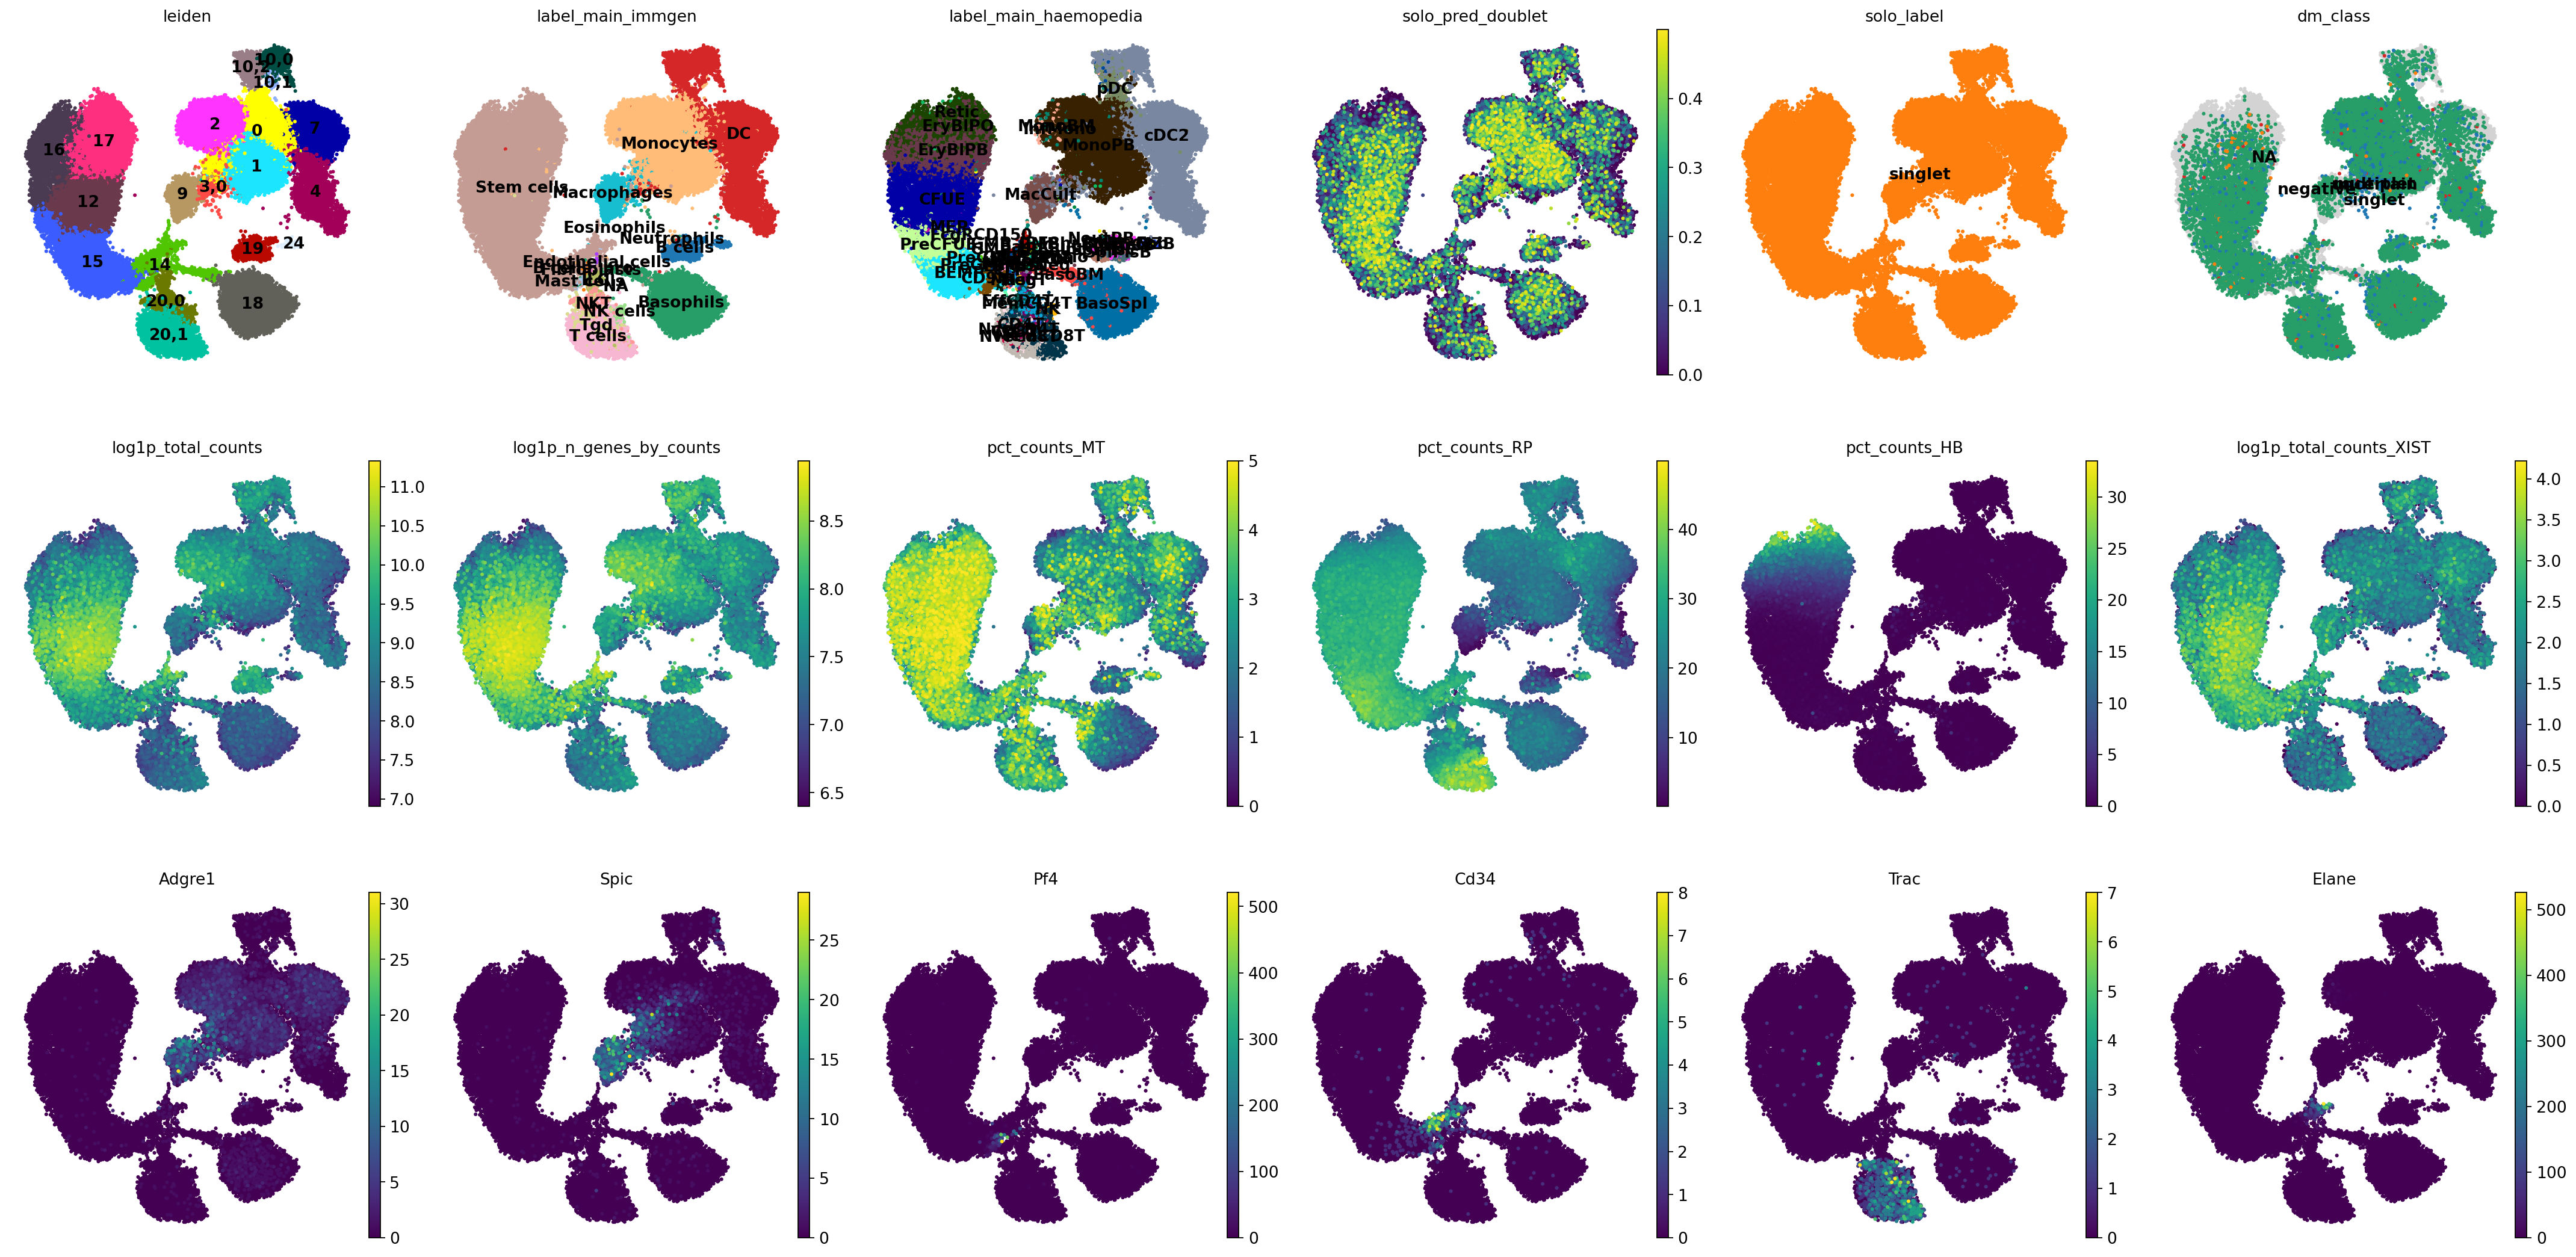

In [14]:
sc.pl.umap(adata, color=['leiden', 'label_main_immgen', 'label_main_haemopedia', 'solo_pred_doublet', 'solo_label', 'dm_class', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_MT', 'pct_counts_RP', 'pct_counts_HB', 'log1p_total_counts_XIST', 'Adgre1', 'Spic', 'Pf4', 'Cd34', 'Trac', 'Elane'], frameon=False, ncols=6, wspace=0.1, size=30, legend_loc='on data', use_raw=False)

## SCVI model 

In [ ]:
adata = adata[:, (adata.X>=3).sum(axis=0)>=3]

In [ ]:
adata = adata.copy()

In [ ]:
cache_scvi = True

In [ ]:
if not cache_scvi: 
    
    scvi.model.SCVI.setup_anndata(
    
        adata, 
        batch_key='sample_group_rep', 
        categorical_covariate_keys=['facility'], 
        continuous_covariate_keys=['S_score', 'G2M_score']
        
    )
    
    model = scvi.model.SCVI(
    
        adata, 
        n_latent=30, 
        n_hidden=128, 
        n_layers=2, 
        gene_likelihood='nb'

    )
    
    max_epochs = int(np.min([round((20000 / adata.n_obs) * 400), 400]))
    
    model.train(max_epochs=max_epochs, check_val_every_n_epoch=1)
    
    model.save('data/scRNAseq/object/scvi/annotation/model/', overwrite=True)
    
else: 
    
    model = scvi.model.SCVI.load('data/scRNAseq/object/scvi/annotation/model/', adata=adata)

In [ ]:
def model_history(model): 
    
    # Plot model history 
    fig, axes=plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
    axes[0].plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')
    axes[0].set_title('Reconstruction Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(model.history['elbo_train']['elbo_train'], label='train')
    axes[1].plot(model.history['elbo_validation']['elbo_validation'], label='validation')
    axes[1].set_title('ELBO')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

In [ ]:
model_history(model)

In [ ]:
cache_dim = True

In [ ]:
if not cache_dim: 
    
    adata.obsm['latent'] = model.get_latent_representation()
    
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='latent')
    sc.tl.leiden(adata, resolution=1, flavor='igraph', n_iterations=2, key_added='leiden')
    sc.tl.umap(adata, min_dist=1)
    
    adata.write_h5ad('data/scRNAseq/object/scvi/annotation/adata.h5ad')
    
else: 
    
    adata = sc.read_h5ad('data/scRNAseq/object/scvi/annotation/adata.h5ad')

In [ ]:
adata = adata.raw.to_adata()
adata.raw = adata.copy()

In [ ]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

In [ ]:
sc.tl.leiden(adata, resolution=0.25, restrict_to=('leiden', ['0']), flavor='igraph', n_iterations=2, key_added='leiden_restrict')
sc.tl.leiden(adata, resolution=0.50, restrict_to=('leiden_restrict', ['8']), flavor='igraph', n_iterations=2, key_added='leiden_restrict')
sc.tl.leiden(adata, resolution=0.25, restrict_to=('leiden_restrict', ['10']), flavor='igraph', n_iterations=2, key_added='leiden_restrict')
sc.tl.leiden(adata, resolution=0.50, restrict_to=('leiden_restrict', ['11']), flavor='igraph', n_iterations=2, key_added='leiden_restrict')

adata.obs['leiden'] = adata.obs['leiden_restrict']
del adata.obs['leiden_restrict']

In [ ]:
sc.pl.umap(adata, color=['leiden', 'facility', 'label_main_immgen', 'label_main_haemopedia', 'S_score', 'G2M_score', 'dm_class', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_MT', 'pct_counts_RP', 'pct_counts_HB', 'log1p_total_counts_XIST'], frameon=False, ncols=6, wspace=0.1, size=30, legend_loc='on data', use_raw=False)

In [ ]:
dp = sc.pl.dotplot(adata, celltype_genes_dict, groupby='leiden', standard_scale='var', use_raw=False, dendrogram=False, return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap='Reds').show()

In [ ]:
celltype_leiden = {

    '0,0': 'intMo (0,0)',
    '0,1': 'cMo (0,1)',
    '0,2': 'cMo (0,2)',
    '0,3': 'intMo (0,3)',
    '1': 'RPM (1)',
    '2': 'ncMo (2)',
    '3': 'moDC (3)',
    '4': 'cDC2 (4)',
    '5': 'cDC mig. (5)',
    '6': 'cDC1 (6)',
    '7': 'Proerythroblast (7)',
    '8,0': 'Erythroblast (8,0)',
    '8,1': 'Erythroblast (8,1)',
    '8,2': 'Proerythroblast (8,2)',
    '8,3': 'Erythroblast (8,3)',
    '8,4': 'Erythroblast (8,4)',
    '9': 'Erythroblast (9)',
    '10,0': 'MEP (10,0)',
    '10,1': 'MEP (10,1)',
    '10,2': 'MegP (10,2)',
    '11,0': 'NeuP (11,0)',
    '11,1': 'BasoP (11,1)',
    '11,2': 'GMP (11,2)',
    '11,3': 'BasoP (11,3)',
    '11,4': 'MastP (11,4)',
    '11,5': 'MegP (11,5)',
    '12': 'Basophil (12)',
    '13': 'Plasma cell (13)',
    '14': 'B cell (14)',
    '15': 'T cell/ILC (15)',
    '16': 'T cell/ILC (16)'
    
}

In [ ]:
# Mapper 
celltype_leiden = pd.DataFrame({'celltype_leiden': adata.obs['leiden'].map(lambda x: celltype_leiden.get(x, x)).astype('category')})
adata.obs = adata.obs.merge(celltype_leiden, left_index=True, right_index=True, how='left')

In [ ]:
adata.obs['celltype_leiden'] = adata.obs['celltype_leiden'].cat.reorder_categories([

    'NeuP (11,0)',
    'BasoP (11,1)',
    'BasoP (11,3)',
    'Basophil (12)',
    'MastP (11,4)',
    'cMo (0,2)',   
    'cMo (0,1)',
    'intMo (0,0)',
    'intMo (0,3)',
    'ncMo (2)',
    
    'RPM (1)',
    
    'moDC (3)',
    'cDC1 (6)',
    'cDC2 (4)',
    'cDC mig. (5)',

    'MegP (10,2)',
    'MegP (11,5)',
    'MEP (10,0)',
    'MEP (10,1)',
    
    'Proerythroblast (7)',
    'Proerythroblast (8,2)',
    'Erythroblast (8,0)',
    'Erythroblast (8,1)',
    'Erythroblast (8,3)',
    'Erythroblast (8,4)',
    'Erythroblast (9)', 
    
    'GMP (11,2)',
    
    'T cell/ILC (15)',
    'T cell/ILC (16)',
    
    'B cell (14)',
    'Plasma cell (13)'
    
])

In [ ]:
dp = sc.pl.dotplot(adata, celltype_genes_dict, groupby='celltype_leiden', standard_scale='var', use_raw=False, dendrogram=False, return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap='Reds').show()

In [ ]:
celltype_low = {
    
    '0,0': 'intMo',
    '0,1': 'cMo',
    '0,2': 'cMo',
    '0,3': 'intMo',
    '1': 'RPM',
    '2': 'ncMo',
    '3': 'moDC',
    '4': 'cDC2',
    '5': 'cDC mig.',
    '6': 'cDC1',
    '7': 'Proerythroblast',
    '8,0': 'Erythroblast',
    '8,1': 'Erythroblast',
    '8,2': 'Proerythroblast',
    '8,3': 'Erythroblast',
    '8,4': 'Erythroblast',
    '9': 'Erythroblast',
    '10,0': 'MEP',
    '10,1': 'MEP',
    '10,2': 'MegP',
    '11,0': 'NeuP',
    '11,1': 'BasoP',
    '11,2': 'GMP',
    '11,3': 'BasoP',
    '11,4': 'MastP',
    '11,5': 'MegP',
    '12': 'Basophil',
    '13': 'Plasma cell',
    '14': 'B cell',
    '15': 'T cell/ILC',
    '16': 'T cell/ILC'
    
}

In [ ]:
# Mapper 
celltype_low = pd.DataFrame({'celltype_low': adata.obs['leiden'].map(lambda x: celltype_low.get(x, x)).astype('category')})
adata.obs = adata.obs.merge(celltype_low, left_index=True, right_index=True, how='left')

In [ ]:
adata.obs['celltype_low'] = adata.obs['celltype_low'].cat.reorder_categories([

    'GMP',
    
    'NeuP',
    
    'BasoP',
    'Basophil',
    
    'MastP',
    
    'cMo',
    'intMo',
    'ncMo',
    
    'RPM',
    
    'moDC',
    'cDC1',
    'cDC2',
    'cDC mig.',
    
    'MegP',
    'MEP',
    'Proerythroblast',
    'Erythroblast',
    
    'T cell/ILC',
    'B cell',
    'Plasma cell'

])

In [ ]:
dp = sc.pl.dotplot(adata, celltype_genes_dict, groupby='celltype_low', standard_scale='var', use_raw=False, dendrogram=False, return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap='Reds').show()

# Remove some artefacts and lymphoid cells 

In [ ]:
sc.tl.leiden(adata, resolution=0.5, restrict_to=('leiden', ['11,0']), flavor='igraph', n_iterations=2, key_added='leiden_tmp')
sc.tl.leiden(adata, resolution=0.5, restrict_to=('leiden_tmp', ['11,2']), flavor='igraph', n_iterations=2, key_added='leiden_tmp')
sc.tl.leiden(adata, resolution=0.5, restrict_to=('leiden_tmp', ['6']), flavor='igraph', n_iterations=2, key_added='leiden_tmp')
adata = adata[~adata.obs.leiden_tmp.isin(['11,0,2', '11,2,0', '6,1'])]

In [ ]:
adata = adata[~adata.obs.celltype_low.isin(['Plasma cell', 'T cell/ILC', 'B cell'])]

# Set color

In [ ]:
# Set colors
set_color(list(color.keys()))

In [ ]:
sc.pl.umap(adata, color=['leiden', 'leiden_tmp', 'celltype_low', 'label_main_immgen', 'label_main_haemopedia', 'facility', 'infection', 'genotype', 'dpi', 'S_score_scale', 'G2M_score_scale', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts_MT', 'log1p_total_counts_RP', 'pct_counts_HB', 'log1p_total_counts_XIST'], frameon=False, ncols=6, wspace=0.1, size=20, legend_loc='on data', use_raw=False)

# Remove some ambagious cells 

# Set raw 

In [ ]:
adata = adata.copy()

In [ ]:
adata = adata.raw.to_adata()
adata.raw = adata

# Save results 

In [ ]:
adata.write_h5ad('data/scRNAseq/object/pp.h5ad')

In [ ]:
cnt = adata.X.T.todense()
cell_id = adata.obs_names
gene_id = adata.var_names
meta = adata.obs
umap = adata.obsm['X_umap']
latent = adata.obsm['latent']

In [ ]:
%%R -i cnt -i cell_id -i gene_id -i meta -i umap -i latent

colnames(cnt) <- cell_id
rownames(cnt) <- gene_id

so <- Seurat::CreateSeuratObject(cnt, meta.data=meta, assay='RNA')

colnames(umap) <- paste0('UMAP_', 1:ncol(umap))
rownames(umap) <- cell_id
so[['umap']] <- Seurat::CreateDimReducObject(embeddings=as.matrix(umap), key='UMAP_', assay='RNA')

colnames(latent) <- paste0('LATENT_', 1:ncol(latent))
rownames(latent) <- cell_id
so[['latent']] <- Seurat::CreateDimReducObject(embeddings=as.matrix(latent), key='LATENT_', assay='RNA')

saveRDS(so, 'data/scRNAseq/object/pp.rds')